In [1]:
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns, nltk

from datasets import load_dataset
from tqdm import tqdm

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix as conf_matrix, classification_report as class_report

import torch, torch.optim as optim, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, DebertaForSequenceClassification

from nltk.corpus import stopwords as stop
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
# df.head(10)

df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df['v1'] = df['v1'].map({'spam': 0, 'ham': 1})

df.head(10)

,v1,v2
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."
5,0,FreeMsg Hey there darling it's been 3 week's n...
6,1,Even my brother is not like to speak with me. ...
7,1,As per your request 'Melle Melle (Oru Minnamin...
8,0,WINNER!! As a valued network customer you have...
9,0,Had your mobile 11 months or more? U R entitle...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


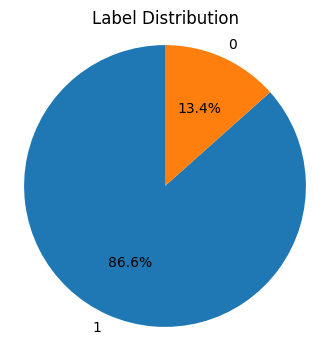

In [4]:
v_ct = df['v1'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(v_ct, labels =v_ct.index, autopct = '%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()

# Severely unbalanced in "Ham"'s favor

In [5]:
df.groupby('v1')['v2'].count()

v1
0     747
1    4825
Name: v2, dtype: int64

In [6]:
from sklearn.utils import resample

df_ham = df[(df['v1'] == 1)]
df_spam = df[(df['v1'] == 0)]

ent = [df_ham, df_spam]
ent_resamp_list = []

for sent in ent:
  ent_resamp = resample(sent, replace = True, n_samples = 1000, random_state = 0)
  ent_resamp_list.append(ent_resamp)

df = pd.concat(ent_resamp_list)

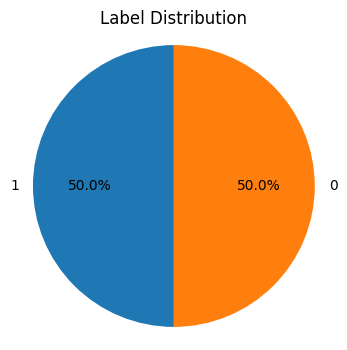

In [7]:
v_ct = df['v1'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(v_ct, labels =v_ct.index, autopct = '%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Label Distribution')
plt.show()

# Now Balanced

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 3158 to 3109
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      2000 non-null   int64 
 1   v2      2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


In [9]:
# Text Preprocessing
xtr, xtemp, ytr, ytemp = tts(df['v2'], df['v1'], test_size = 0.2, stratify = df['v1'], random_state = 42)
xvl, xts, yvl, yts = tts(xtemp, ytemp, test_size = 0.5, stratify = ytemp, random_state = 42)

# Tokenize text
seq_len = [len(seq) for seq in df['v2']]
maxlen = max(seq_len)

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

xtr_enc = tokenizer(
    xtr.tolist(),
    padding = True,
    truncation = True,
    max_length = maxlen,
    return_tensors = 'pt'
)
xtr_ii = xtr_enc['input_ids']
xtr_am = xtr_enc['attention_mask']

xvl_enc = tokenizer(
    xvl.tolist(),
    padding = True,
    truncation = True,
    max_length = maxlen,
    return_tensors = 'pt'
)
xvl_ii = xvl_enc['input_ids']
xvl_am = xvl_enc['attention_mask']

xts_enc = tokenizer(
    xts.tolist(),
    padding = True,
    truncation = True,
    max_length = maxlen,
    return_tensors = 'pt'
)
xts_ii = xts_enc['input_ids']
xts_am = xts_enc['attention_mask']

ytr = torch.tensor(ytr.values)
yvl = torch.tensor(yvl.values)
yts = torch.tensor(yts.values)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Loading Data into Torch-Usable Format
class TextData(Dataset):
    def __init__(self, x_ii, x_am, y):
        self.x_ii = x_ii
        self.x_am = x_am
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'input_ids': self.x_ii[idx],
            'attention_mask': self.x_am[idx],
            'labels': self.y[idx]
        }

# Create dataset
tr_dt = TextData(xtr_ii, xtr_am, ytr)
val_dt = TextData(xvl_ii, xvl_am, yvl)
ts_dt = TextData(xts_ii, xts_am, yts)

tr_dl = DataLoader(tr_dt, batch_size = 40, shuffle = True)
val_dl = DataLoader(val_dt, batch_size = 40)
ts_dl = DataLoader(ts_dt, batch_size = 40)

In [11]:
# Training Loop
def tr_1ep(mod, dload, optimizer, criterion, device):
    mod.train()
    tr_ls = 0.0 
    correct = 0
    total = 0

    for batch in tqdm(dload, desc="Training"):
        ii = batch['input_ids'].to(device)
        am = batch['attention_mask'].to(device)
        y = batch['labels'].to(device)

        # Forward pass
        outs = mod(ii, attention_mask=am, labels=y)
        loss = outs.loss
        logits = outs.logits

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Epoch Evaluation
        tr_ls += loss.item() * ii.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += torch.sum(preds == y).item()
        total += y.size(0)  
        
    avg_ls = tr_ls / total
    acc = correct / total

    return avg_ls, acc

# Validation Loop
def val_1ep(mod, dload, criterion, device):
    mod.eval()
    val_ls = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dload, desc="Validation"):
            ii = batch['input_ids'].to(device)
            am = batch['attention_mask'].to(device)
            y = batch['labels'].to(device)

            outs = mod(ii, attention_mask=am, labels=y)
            loss = outs.loss
            logits = outs.logits

            val_ls += loss.item() * ii.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += torch.sum(preds == y).item()
            total += y.size(0)
            
    avg_ls = val_ls / total
    acc = correct / total

    return avg_ls, acc

# Trainer
def tr_mod(mod, tr_dl, val_dl, optimizer, criterion, epochs, device):
    hist = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        tr_ls, tr_acc = tr_1ep(mod, tr_dl, optimizer, criterion, device)
        print(f'Train Loss: {tr_ls:.4f}, Train Accuracy: {tr_acc:.4f}')
        
        # Validation
        val_ls, val_acc = val_1ep(mod, val_dl, criterion, device)  # Use val_dl (was val_ld before)
        print(f'Validation Loss: {val_ls:.4f}, Validation Accuracy: {val_acc:.4f}')
        
        # Save history
        hist['train_loss'].append(tr_ls)
        hist['train_acc'].append(tr_acc)
        hist['val_loss'].append(val_ls)
        hist['val_acc'].append(val_acc)
           
    return hist

In [12]:
# Building Model
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2)

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr = 1e-6)
criterion = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

history = tr_mod(
    model,
    tr_dl,
    val_dl,
    optimizer,
    criterion,
    15,# epochs
    device
)
torch.save(model.state_dict(), 'deberta_model_v1.pth')
print("Model weights saved successfully.")

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15


Training: 100%|██████████| 40/40 [00:26<00:00,  1.51it/s]


Train Loss: 0.6848, Train Accuracy: 0.5706


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Validation Loss: 0.6463, Validation Accuracy: 0.8900
Epoch 2/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.5857, Train Accuracy: 0.7744


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Validation Loss: 0.5020, Validation Accuracy: 0.9500
Epoch 3/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.4741, Train Accuracy: 0.8819


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Validation Loss: 0.4239, Validation Accuracy: 0.9750
Epoch 4/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.4193, Train Accuracy: 0.9331


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Validation Loss: 0.3860, Validation Accuracy: 0.9750
Epoch 5/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.3862, Train Accuracy: 0.9594


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Validation Loss: 0.3638, Validation Accuracy: 0.9750
Epoch 6/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.3660, Train Accuracy: 0.9669


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


Validation Loss: 0.3477, Validation Accuracy: 0.9800
Epoch 7/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.3515, Train Accuracy: 0.9731


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Validation Loss: 0.3339, Validation Accuracy: 0.9800
Epoch 8/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.3289, Train Accuracy: 0.9844


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Validation Loss: 0.3202, Validation Accuracy: 0.9850
Epoch 9/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.3136, Train Accuracy: 0.9844


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Validation Loss: 0.3096, Validation Accuracy: 0.9850
Epoch 10/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.3007, Train Accuracy: 0.9850


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Validation Loss: 0.3000, Validation Accuracy: 0.9850
Epoch 11/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.2889, Train Accuracy: 0.9862


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Validation Loss: 0.2898, Validation Accuracy: 0.9800
Epoch 12/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.2819, Train Accuracy: 0.9844


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


Validation Loss: 0.2794, Validation Accuracy: 0.9900
Epoch 13/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.2611, Train Accuracy: 0.9925


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Validation Loss: 0.2623, Validation Accuracy: 0.9900
Epoch 14/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.2538, Train Accuracy: 0.9888


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Validation Loss: 0.2531, Validation Accuracy: 0.9750
Epoch 15/15


Training: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Train Loss: 0.2312, Train Accuracy: 0.9875


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


Validation Loss: 0.2107, Validation Accuracy: 0.9900
Model weights saved successfully.


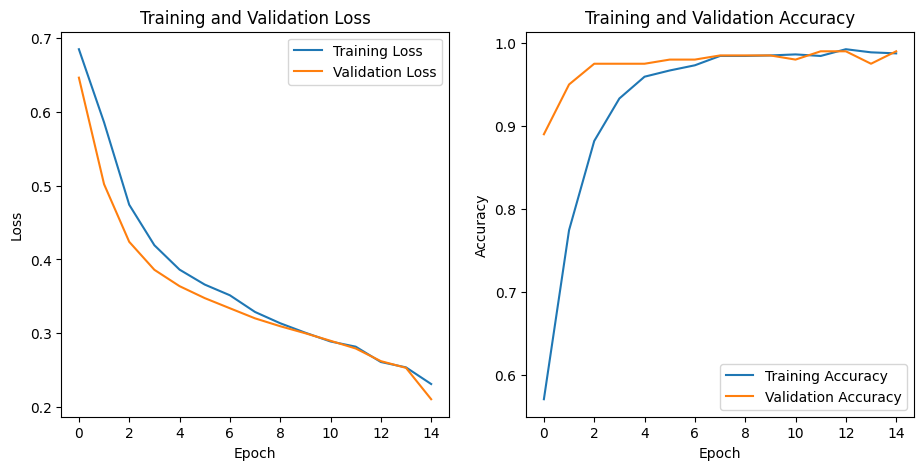

In [13]:
# Plotting Model History
epochs = 10

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
# Evaluation on Test Set
ts_ls_hist = []
ts_acc_hist = []

for i in range(20):
    ts_ls, ts_acc = val_1ep(model, ts_dl, criterion, device)
    ts_ls_hist.append(ts_ls)
    ts_acc_hist.append(ts_acc)
    
avg_ts_ls = np.mean(ts_ls_hist)
avg_ts_acc = np.mean(ts_acc_hist)

print(f"Average Test Loss: {avg_ts_ls}")
print(f"Average Test Accuracy: {avg_ts_acc}")

Validation: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

Average Test Loss: 0.2088908314704895
Average Test Accuracy: 0.9750000000000002


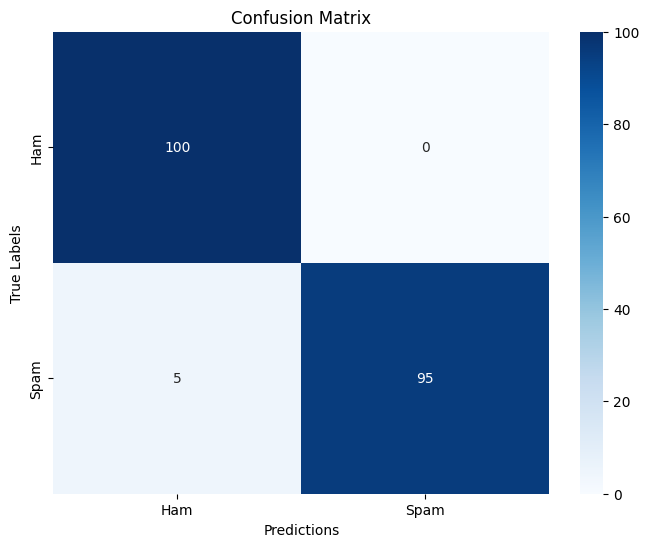

In [15]:
# Confusion Matrix
model.eval()
ypr_all = []
ytrue_all = []

with torch.no_grad():
    for batch in ts_dl:
        ii = batch['input_ids'].to(device)
        am = batch['attention_mask'].to(device)
        y = batch['labels'].to(device)

        outs = model(ii, attention_mask = am)
        logits = outs.logits
        preds = torch.argmax(logits, dim=1)

        ypr_all.extend(preds.cpu().numpy())
        ytrue_all.extend(y.cpu().numpy())

conf_mtx = conf_matrix(ytrue_all, ypr_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

In [16]:
# Classification Report
cls_rpt = class_report(ytrue_all, ypr_all, target_names=['Ham', 'Spam'])
print(f"Classification Report:\n{cls_rpt}")

Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.98       100
        Spam       1.00      0.95      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

